### This script is used to extract leaks

### Input packages

In [2]:
from pandas import read_csv
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook
import pickle
import numpy as np
from imagehash import phash
from math import sqrt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Input label Info.

In [4]:
train_a = dict([(p,w) for _,p,w in read_csv('whale_palyground/train.csv').to_records()])
test_b = [p for _,p,_ in read_csv('all/sample_submission.csv').to_records()]
join   = list(train_a.keys()) + test_b

In [6]:
# get image size
def expand_path(p):
    if isfile('whale_palyground/train/' + p): return 'whale_palyground/train/' + p
    if isfile('all/test/' + p): return 'all/test/' + p
    return p

p2size = {}
for p in tqdm_notebook(join):
    size      = pil_image.open(expand_path(p)).size
    p2size[p] = size
len(p2size), list(p2size.items())[:5]

(17810,
 [('00022e1a.jpg', (699, 500)),
  ('000466c4.jpg', (1050, 700)),
  ('00087b01.jpg', (1050, 368)),
  ('001296d5.jpg', (397, 170)),
  ('0014cfdf.jpg', (700, 398))])

### Detect same images

The following cell comes from Martin's kernel, which utilizes imagehash to detect same images. In the future, we can also use more advanced techniques to replace this method

all comments in red color are written by Martin, I just keep his useful parts

In [8]:
'''
Read or generate p2h, a dictionary of image name to image id (picture to hash)

Two phash values are considered duplicate if, for all associated image pairs:
1) They have the same mode and size;
2) After normalizing the pixel to zero mean and variance 1.0, the mean square error does not exceed 0.1
'''

def match(h1,h2):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 =  pil_image.open(expand_path(p1))
            i2 =  pil_image.open(expand_path(p2))
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1/sqrt((a1**2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2/sqrt((a2**2).mean())
            a  = ((a1 - a2)**2).mean()
            if a > 0.1: return False
    return True

if isfile('all/p2h_2test.pickle'):
    with open('all/p2h_2test.pickle', 'rb') as f:
        p2h = pickle.load(f)
else:
    '''
    Compute phash for each image in the training and test set.
    ''' 
    p2h = {}
    for p in tqdm_notebook(join):
        img    = pil_image.open(expand_path(p))
        h      = phash(img)
        p2h[p] = h
    '''
    Find all images associated with a given phash value.
    '''
    h2ps = {}
    for p,h in p2h.items():
        if h not in h2ps: h2ps[h] = []
        if p not in h2ps[h]: h2ps[h].append(p)

    '''
    Find all distinct phash values
    '''
    hs = list(h2ps.keys())
    '''
    If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
    '''
    h2h = {}
    for i,h1 in enumerate(tqdm_notebook(hs)):
        for h2 in hs[:i]:
            if h1-h2 <= 6 and match(h1, h2):
                s1 = str(h1)
                s2 = str(h2)
                if s1 < s2: s1,s2 = s2,s1
                h2h[s1] = s2

    '''
    Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
    '''
    for p,h in p2h.items():
        h = str(h)
        if h in h2h: h = h2h[h]
        p2h[p] = h
    with open('all/p2h_2test.pickle', 'wb') as f: pickle.dump(p2h, f)
        
len(p2h), list(p2h.items())[:5]

(17810,
 [('00022e1a.jpg', 'b362cc79b1a623b8'),
  ('000466c4.jpg', 'b3cccc3331cc8733'),
  ('00087b01.jpg', 'bc4ed0f2a7e168a8'),
  ('001296d5.jpg', '93742d9a28b35b87'),
  ('0014cfdf.jpg', 'd4a1dab1c49f6352')])

In [9]:
# For each image hash id, determine the list of pictures
h2ps = {}
for p,h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)
# Notice how 17810 images use only 16738 distinct image ids.
len(h2ps),list(h2ps.items())[:5]

(16738,
 [('b362cc79b1a623b8', ['00022e1a.jpg']),
  ('b3cccc3331cc8733', ['000466c4.jpg']),
  ('bc4ed0f2a7e168a8', ['00087b01.jpg']),
  ('93742d9a28b35b87', ['001296d5.jpg']),
  ('d4a1dab1c49f6352', ['0014cfdf.jpg'])])

In [10]:
#a function that can plot an example of duplicate images
import matplotlib.pyplot as plt

def show_whale(imgs, per_row=2):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))
    plt.show()

In [25]:
#get duplicate images
dup_list = {}
for h, ps in h2ps.items():
    if len(ps) >= 2:
        dup_list[h] = ps
#get each images' label, and dataset
aug_list = {}
for h, img_list in dup_list.items():
    tmp_list = []
    for img in img_list:
        if img in train_a:
            # use 0 to represent playground data, 1 to represent current data
            tmp_list.append((img, train_a[img], 0))
        else:
            tmp_list.append((img, np.nan, 1))
    aug_list[h] = tmp_list

In [26]:
#convert dict to pandas dataframe for conveniences
import pandas as pd
aug_list = pd.DataFrame.from_dict(aug_list, orient='index')
aug_list.reset_index(inplace=True)
aug_list.drop(['index'], axis=1, inplace=True)
aug_list.columns = ['img1','img2','img3']

In [27]:
def split_image(x, place):
    try:
        return x[place]
    except:
        return np.nan

In [28]:
def split_img_tuple(col, df):
    img_name = col + '_name'
    img_label = col + '_label'
    img_dataset = col + '_dataset'
    df[img_name] = df[col].apply(lambda x: split_image(x, 0))
    df[img_label] = df[col].apply(lambda x: split_image(x, 1))
    df[img_dataset] = df[col].apply(lambda x: split_image(x, 2))
    df.drop([col], axis=1, inplace=True)
    return df
aug_list = split_img_tuple('img1', aug_list)
aug_list = split_img_tuple('img2', aug_list)
aug_list = split_img_tuple('img3', aug_list)

In [29]:
#remove the column, if all images are coming from A
aug_list[aug_list['img3_dataset'].isnull() == False]

,img1_name,img1_label,img1_dataset,img2_name,img2_label,img2_dataset,img3_name,img3_label,img3_dataset
547,59becb6c.jpg,new_whale,0,cc68d9f2.jpg,w_cae7677,0,eb026a29.jpg,w_cae7677,0.0
960,bd069141.jpg,w_d9055d1,0,cba81909.jpg,new_whale,0,cf0f99d2.jpg,w_d9055d1,0.0


In [30]:
aug_list = aug_list[aug_list['img3_dataset'].isnull() != False]
aug_list.dropna(axis = 1,inplace = True)

In [37]:
aug_list = aug_list[aug_list['img2_dataset'] == 1]
aug_list.drop(['img1_dataset','img2_dataset'], axis=1, inplace=True)
aug_list = aug_list[aug_list['img1_label'] != 'new_whale']

In [45]:
aug_list.head(2)

,img1_name,img1_label,img2_name
3,00467ae9.jpg,w_fd1cb9d,781c0ad2c.jpg
8,010ecbb5.jpg,w_7b3f9d1,990ac119c.jpg


### Input label mapping

In [44]:
label_mapping = pd.read_csv('all/all_label_mapping.csv')
label_mapping.columns = ['img1_label','img2_label']
aug_list = aug_list.merge(label_mapping, on='img1_label', how='left')

In [58]:
leaks = aug_list[aug_list['img2_label'].isnull() == False]

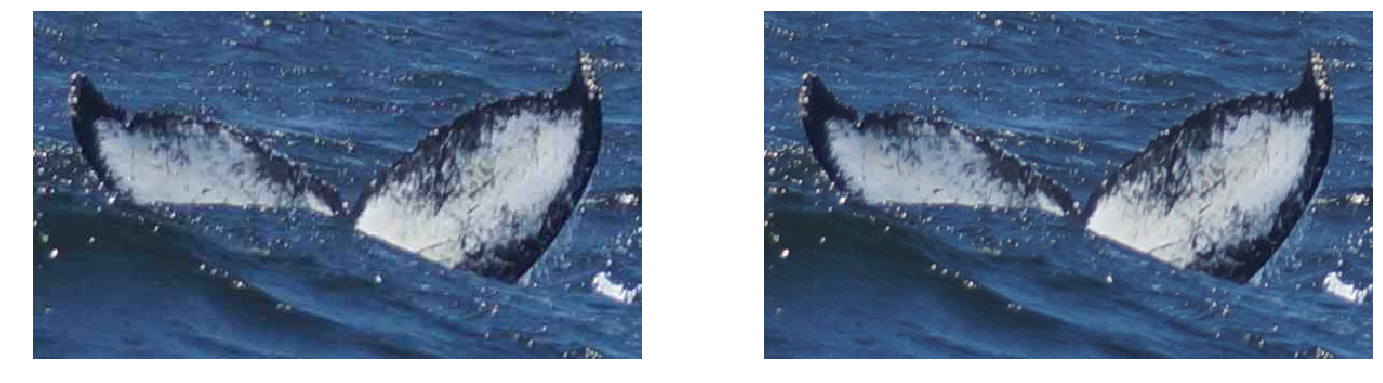

In [62]:
#Here we can see some leak images
imgs = [pil_image.open(expand_path(p)) for p in ['010ecbb5.jpg','990ac119c.jpg']]
show_whale(imgs, per_row=2)

In [60]:
leaks_output = leaks[['img2_name','img2_label']]
leaks_output.columns = [['b_test_img','b_label']]

### Output

In [61]:
leaks_output.to_csv('all/leaks.csv', index=False)